## Parse model config yaml file

In [1]:
from app.features.model.schema.configs import ModelConfig
import yaml

config = """name: GNNExample

dataset:
  name: test_dataset_2
  target_column: tpsa
  feature_columns:
    - smiles
    - mwt

featurizers:
  - name: MolToGraphFeaturizer
    type: app.features.model.featurizers.MoleculeFeaturizer
    input:
      - smiles
    args:
      allow_unknown: false
      sym_bond_list: true
      per_atom_fragmentation: false

layers:

  # Start fst branch (from featurizer)
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 30
      out_channels: 64
    input: MolToGraphFeaturizer

  - name: GCN1_Activation
    type: torch.nn.ReLU
    input: GCN1

  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    input: GCN1_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN2_Activation
    type: torch.nn.ReLU
    input: GCN2

  - name: GCN3
    type: torch_geometric.nn.GCNConv
    input: GCN2_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN3_Activation
    type: torch.nn.ReLU
    input: GCN3

  - name: AddPool
    type: app.features.model.layers.GlobalPooling
    input: GCN3_Activation
    args:
      aggr: 'sum'
  # End of fst branch

  # Second branch would simply be linear layers in mwt
  - name: Linear1
    type: torch.nn.Linear
    args:
      in_features: 1
      out_features: 10
    input: mwt

  - name: Combiner
    type: app.features.model.layers.Concat
    input: ['AddPool', 'Linear1']

  - name: LinearJoined
    type: torch.nn.Linear
    input: Combiner
    args:
      in_features: 74
      out_features: 1

  - name: OutputSigmoid
    type: torch.nn.Sigmoid
    input: LinearJoined
"""

model = ModelConfig.from_yaml(config)
model

ModelConfig(name='GNNExample', dataset=DatasetConfig(name='test_dataset_2', target_column='tpsa', feature_columns=['smiles', 'mwt']), featurizers=[AppmoleculefeaturizerLayerConfig(name='MolToGraphFeaturizer', input=['smiles'], type='app.features.model.featurizers.MoleculeFeaturizer', args=AppmoleculefeaturizerArgs(allow_unknown=False, sym_bond_list=True, per_atom_fragmentation=False))], layers=[TorchgeometricgcnconvLayerConfig(name='GCN1', input='MolToGraphFeaturizer', type='torch_geometric.nn.GCNConv', args=TorchgeometricgcnconvArgs(in_channels=30, out_channels=64)), TorchreluLayerConfig(name='GCN1_Activation', input='GCN1', type='torch.nn.ReLU'), TorchgeometricgcnconvLayerConfig(name='GCN2', input='GCN1_Activation', type='torch_geometric.nn.GCNConv', args=TorchgeometricgcnconvArgs(in_channels=64, out_channels=64)), TorchreluLayerConfig(name='GCN2_Activation', input='GCN2', type='torch.nn.ReLU'), TorchgeometricgcnconvLayerConfig(name='GCN3', input='GCN2_Activation', type='torch_geomet

In [2]:
import torch_geometric.nn as geom_nn
from app.features.model.layers import GlobalPooling
from app.features.model.layers import Concat

# detour. how to check the forward signature?

edge_index_classes = ( geom_nn.MessagePassing )
pooling_classes = ( GlobalPooling )

def is_message_passing(layer):
    """ x = layer(x, edge_index) """
    return isinstance(layer, geom_nn.MessagePassing)

def is_graph_pooling(layer):
    """ x = layer(x, batch) """
    return isinstance(layer, pooling_classes)

def is_concat_layer(layer):
    return isinstance(layer, Concat)

for layer in model.layers:
    layer_instance = layer.create()

    if is_message_passing(layer_instance):
        print(f'{layer.type} gets passed (x, edge_index)')
    elif is_graph_pooling(layer_instance):
        print(f'{layer.type} gets passed (x, batch)')
    elif is_concat_layer(layer_instance):
        print(f'{layer.type} gets passed (x1, x2)')
    else:
        print(f'{layer.type} gets passed (x)')


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch_geometric.nn.GCNConv gets passed (x, edge_index)
torch.nn.ReLU gets passed (x)
torch_geometric.nn.GCNConv gets passed (x, edge_index)
torch.nn.ReLU gets passed (x)
torch_geometric.nn.GCNConv gets passed (x, edge_index)
torch.nn.ReLU gets passed (x)
app.features.model.layers.GlobalPooling gets passed (x, batch)
torch.nn.Linear gets passed (x)
app.features.model.layers.Concat gets passed (x1, x2)
torch.nn.Linear gets passed (x)
torch.nn.Sigmoid gets passed (x)


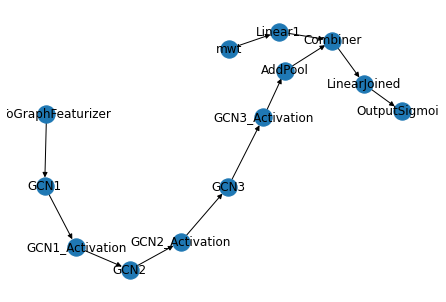

In [3]:
import networkx as nx

nx.draw(model.make_graph(), with_labels=True)

### Input Example

In [91]:
from torch_geometric.data import Data
import torch

print('#### Data Graph ####')
print()

x = torch.ones(3, 30, dtype=torch.float)
print(f'\tExample of Graph X: {x}')
print()

edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
print(f'\tExample of Graph edge_index: {edge_index}')
print()

print('#### Example of tensor ####')
print()

mwt = torch.tensor([[230.], [210.], [410.], [430.], [235.]], dtype=torch.float)
print(f'\tExample of mwt tensor: {mwt}')
print()


print('#### Example of Dataset __getitem__ ####')
print()

dataset_input = {
    'MolToGraphFeaturizer': Data(x=x, edge_index=edge_index, batch),
    'mwt': mwt
}

dataset_input['MolToGraphFeaturizer'].batch
# dataset_input

#### Data Graph ####

	Example of Graph X: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

	Example of Graph edge_index: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

#### Example of tensor ####

	Example of mwt tensor: tensor([[230.],
        [210.],
        [410.],
        [430.],
        [235.]])

#### Example of Dataset __getitem__ ####



### Custom Model

In [94]:
from typing import Any, Dict, Union


class Adapter:
    """
    """
    @staticmethod
    def forward_pass(
        self,
        input_dict: Dict[str, Union[torch.Tensor, Data]],
        current_layer_name: str,
        graph: nx.DiGraph,
    ) -> "InputTarget":
        """
        """
        pass

In [135]:
# Implement module forward
from typing import Dict, Union
import torch
import torch.nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data

CustomDatasetIn = Dict[str, Union[torch.Tensor, Data]]


class CustomModel(torch.nn.Module):

    def __init__(self, config: ModelConfig):
        super().__init__()
        
        self.config = config

        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()

        self.layers = torch.nn.ModuleDict(layers_dict)

        self.layer_configs = {
            l.name: l for l in config.layers
        }

        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
    
    def forward(self, input_: CustomDatasetIn):
        storage = input_.copy()

        for index, layer_name in enumerate(self.topo_sorting):
            # Detect if we need to skip a featurizer or input (column) from the dataset
            # that are features, otherwise we are manipulating a layer.
            if not layer_name in self.layers:
                continue

            layer = self.layers[layer_name]
            print(layer)

            # Step 1
            #
            # Detect the previous and next layers
            # We need this information to transform the input and output
            # to perform the correct forward pass.
            previous_layers = [p_layer for p_layer, c_layer in self.graph.in_edges(layer_name)]
            next_layers = [n_layer for c_layer, n_layer in self.graph.out_edges(layer_name)]

            # Step 2
            # 
            # Transform and preprocess the input and output based on the previous
            # and next layers.

            # 2.1   - if its an gnn layer it always have just one input
            if is_message_passing(layer):
                input_source = self.layer_configs[layer_name].input
                # Check if comes from other layer or the dataset
                if not input_source in self.layers:
                    # If comes from the dataset we need to extract the x and edge_index
                    x, edge_index = storage[input_source]['x'], storage[input_source]['edge_index']

                    print('\tInput:')
                    print('\t\t', x)
                    print('\t\t', edge_index)

                    layer_output = layer(x=x, edge_index=edge_index), edge_index
                    print('\tOutput:')
                    print('\t\t', layer_output)

                else:
                    # Otherwise we take as an input a tuple containing the x (node_features)
                    # in the first position and edge_index in the second.
                    continue
                    # TODO: verify if we need to pass the batch with the other features 
                    x, edge_index = storage[input_source][0], storage[input_source][1]
                    layer_output = layer(x=x, edge_index=edge_index), edge_index

            # 2.2   - if its an pooling layer it always have just one input
            #         and the input is composed by x (node_features) from the last layer
            #         and the batch that comes with the data object

            # 2.3   - if its an activation or a mlp/normal layer we need to check the
            #         previous layers to make sure that the input is in the correct format
            #         and check the next layers to format the output
            else:
                input_source = self.layer_configs[layer_name].input
                input_source = [input_source]  else input_source
                # [mwt]
                # [GCN1]
                if isinstance(input_source, str): # Only had one previous layer
                    # If just had one feature to pass we need to check the previous layer
                    # and them determine if we pass the edge_index for the next layer
                    if isinstance(storage[input_source], tuple):
                        # In this case we receive from a MessagePassing
                        
                        # We also need to check if the next layer is a MessagePassing
                        has_gnn_next = False
                        for n_layer in next_layers:
                            if self.layers[]
                        next_layers
                    print(previous_layers[0].)
                else:
                    # [Linear1, AddPool]
                    pass
                    
                print('\t', input_source)

            # 2.3.1 - if the next layer is a gnn layer we need to recover the correct edge_index
            #         if the next layer is a normal layer we just need the result

            ###### OLD - FORWARD ###### 

#             inputs = self.layer_configs[layer_name].input

#             if isinstance(inputs, str): # arrays only
#                 inputs = [inputs]

#             inps = [ outs[input] for input in inputs ]

#             if is_message_passing(layer):
#                 inp = inps[0]
#                 print(f'\tInput: {inp}')

#                 # Detect if the inp is an Data object, otherwise we need to access a dict
#                 # returned from other GCN layer
#                 if isinstance(inp, Data):
#                     x, edge_index = inp.x, inp.edge_index
#                 else:
#                     x, edge_index = inp['x'], inp['edge_index']

#                 # Out preprocess
#                 x = layer(x, edge_index) # We need to store the edge_index for other layers to use them
#                 outs[layer_name] = dict(x=x, edge_index=edge_index)

#             elif is_graph_pooling(layer):
#                 inp = inps[0]
#                 print(f'\tInput: {inp}')
#                 # x, batch = inp.x, inp.batch
#                 # outs[layer_name] = layer(x, batch)

#             else: # concat layers and normal layers
#                 transformed_input = inps.copy()

#                 if isinstance(transformed_input[0], dict):
#                     transformed_input[0] = inps[0]['x']

#                 print(f'\tInput: {inps}')

#                 # Detect if the next layer is a gnn layer
#                 next_layers = [e[1] for e in self.graph.out_edges(layer_name)]
#                 next_layer_is_gnn = False

#                 x = layer(*transformed_input)

#                 for nl in next_layers:
#                     if is_message_passing(self.layers[nl]):
#                         # Means that the next layer is a gcn layer
#                         next_layer_is_gnn = True
#                 if next_layer_is_gnn:
#                     # Adapt the output to a MessagePassing input format
#                     outs[layer_name] = dict(x=x, edge_index=inps[0]['edge_index'])
#                 else:
#                     outs[layer_name] = x

#             # last = outs[layer_name]
        
#         return None

custom_model = CustomModel(model)
custom_model

CustomModel(
  (layers): ModuleDict(
    (GCN1): GCNConv(30, 64)
    (GCN1_Activation): ReLU()
    (GCN2): GCNConv(64, 64)
    (GCN2_Activation): ReLU()
    (GCN3): GCNConv(64, 64)
    (GCN3_Activation): ReLU()
    (AddPool): GlobalPooling(aggr=sum)
    (Linear1): Linear(in_features=1, out_features=10, bias=True)
    (Combiner): Concat()
    (LinearJoined): Linear(in_features=74, out_features=1, bias=True)
    (OutputSigmoid): Sigmoid()
  )
)

In [136]:
custom_model.forward(dataset_input)

GCNConv(30, 64)
	Input:
		 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
		 tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
	Output:
		 (tensor([[-0.7560,  0.0658, -0.0796,  0.9487, -1.0943, -0.4712, -0.6284, -0.9453,
          0.4003, -0.1058, -0.8314, -0.2375, -0.1342, -0.8229, -0.0595, -0.5776,
          0.2084,  0.5101, -1.2855, -0.4165, -0.6712, -0.3578, -0.2476,  0.4144,
         -0.2185, -0.6165, -0.0130, -0.3918, -0.9680, -0.9675,  0.4271,  0.2209,
         -0.3075,  0.3070, -0.9903, -0.0725, -0.0527,  0.4657,  0.6364, -1.3483,
          0.5058,  0.8158,  0.1217,  1.1105, -0.2134, -0.4581,  0.2792,  0.8900,
        